In [19]:
import nltk
import sys
import operator
import pandas as pd
import numpy as np
from tqdm import tqdm
from sklearn.cross_validation import train_test_split
from collections import defaultdict

ModuleNotFoundError: No module named 'sklearn.cross_validation'

In [2]:
import matplotlib.pyplot as plt
%matplotlib inline
%pylab inline

Populating the interactive namespace from numpy and matplotlib


## Train data

In [10]:
import random 
data_train = []
keys = set()
keys.update([''])
n = 10000

cap_letters = ['А', 'Б','В','Г','Д','Е','Ж','З','И','Й','К','Л','М',
               'Н','О','П','Р','С','Т','У','Ф','Х','Ц','Ч','Ш','Щ','Э','Ю','Я']

In [14]:
data = pd.read_csv("./data_15k_with_classes_new.csv", index_col=None).iloc[:, 1:]
train_data, test_data = train_test_split(data, test_size=0.25, random_state=42)

### Building vocabularies

Just like before, we have to build a mapping from tokens to integer ids. This time around, our model operates on a word level, processing one word per RNN step. This means we'll have to deal with far larger vocabulary.

Luckily for us, we only receive those words as input i.e. we don't have to predict them. This means we can have a large vocabulary for free by using word embeddings.

In [15]:
all_chars = set(''.join(data.hashtag.values))
char_to_id = defaultdict(lambda:1,{word:i for i, word in enumerate(all_chars)})
tag_to_id = {tag: i for i, tag in enumerate(['0', '1'])}

In [16]:
len(all_chars)

73

convert words and tags into fixed-size matrix

In [17]:
def to_matrix(lines, token_to_id,
              max_len=None,
              pad=0,
              dtype='int32',
              time_major=False):
    
    """Converts a list of hashtags into rnn-digestable matrix with paddings added after the end"""
    
    max_len = max_len or max(map(len,lines))
    matrix = np.empty([len(lines), max_len], dtype)
    matrix.fill(pad)

    for i in range(len(lines)):
        line_ix = list(map(token_to_id.__getitem__, lines[i]))[:max_len]
        matrix[i,:len(line_ix)] = line_ix

    return matrix.T if time_major else matrix

In [18]:
batch_words, batch_tags = data[:3].hashtag.values, data[:3].true_segmentation.values

print("Word ids:")
print(to_matrix(batch_words, char_to_id))
print("Tag ids:")
print(to_matrix(batch_tags, tag_to_id))

Word ids:
[[41 20 24 17 20 41 40 29 19 19 10 57 36  0  0  0  0  0  0  0  0  0  0  0
   0  0]
 [ 4 40 37 14 54 10 43 36 19 20 40 20  0 36 66 29  4 43 20 47 44 46 29 19
  17 55]
 [66 29 40 20 61 29 43 44 65 65 44 55 20  4  4 36 36  0  0  0  0  0  0  0
   0  0]]
Tag ids:
[[0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 0 0 0 0 1]
 [0 0 0 0 0 0 1 0 0 0 1 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0]]


In [19]:
df = pd.read_csv("data_15k_with_classes_new.csv", index_col=None).iloc[:, 1:]
df.head()

,hashtag,hashtag_class,true_segmentation
0,основногоэтапа,6,00000000100001
1,тактических6762,5,000000000010001
2,славянское9839братствоучений,7,0000000001000100000001000001
3,5североокругазападного,7,1000001000001000000001
4,силино,5,000001


## Test data

2088 – всего хештегов в тестовой выборке 

из которых:
* 239 хештегов с аббревиатурами
* 449 однословные с заглавной буквы
* 269 двусловные разделённые заглавной буквой (в большинстве случаев начинаются тоже с заглавной)
* 53 трехсловные разделённые заглавными буквами (в большинстве случаев начинаются тоже с заглавной)
* 6 четыре слова разделённые заглавными буквами
* 1072 1+ слов без заглавных букв в строке 

In [12]:
real_test_data = pd.read_csv("./real_test_data.csv")

In [14]:
real_test_data.columns

Index(['Unnamed: 0', 'hashtag', 'true_segmentation', 'flag'], dtype='object')

In [16]:
real_test_data.drop(['Unnamed: 0'], inplace=True, axis=1)
real_test_data.head()

,hashtag,true_segmentation,flag
0,ЁлкаВЗазеркалье,000110000000001,False
1,АКЕРБАТ,0000001,False
2,АКИТ,0001,False
3,АРМИ,0001,False
4,Абхазия,0000001,False


In [18]:
real_test_data.shape

(1950, 3)

## Building model

By default, all keras RNNs apply to a whole sequence of inputs and produce a sequence of hidden states `(return_sequences=True` or just the last hidden state `(return_sequences=False)`. All the recurrence is happening under the hood.

At the top of our model we need to apply a Dense layer to each time-step independently. As of now, by default keras.layers.Dense would apply once to all time-steps concatenated. We use __keras.layers.TimeDistributed__ to modify Dense layer so that it would apply across both batch and time axes.

In [25]:
import keras
import keras.layers as L

model = keras.models.Sequential()
model.add(L.InputLayer([None], dtype='int32'))
model.add(L.Embedding(len(all_chars), 50)) # dim 100
model.add(L.Bidirectional(L.LSTM(64, return_sequences=True)))

#add top layer that predicts tag probabilities
stepwise_dense = L.Dense(2, activation='softmax')
stepwise_dense = L.TimeDistributed(stepwise_dense)
model.add(stepwise_dense)

/Users/apple/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


__Training:__ in this case we don't want to prepare the whole training dataset in advance. The main cause is that the length of every batch depends on the maximum sentence length within the batch. This leaves us two options: use custom training code or use generators.

Keras models have a __`model.fit_generator`__ method that accepts a python generator yielding one batch at a time. But first we need to implement such generator:

In [26]:
from keras.utils.np_utils import to_categorical

BATCH_SIZE=32
def generate_batches(sentences, batch_size=BATCH_SIZE, max_len=None, pad=0):
    
    assert isinstance(sentences,pd.DataFrame), "Make sure sentences is q pd dataframe"
    
    
    while True:
        indices = np.random.permutation(np.arange(len(sentences)))
        for start in range(0,len(indices)-1,batch_size):
            batch_indices = indices[start:start+batch_size]
            batch_sentences = sentences.iloc[batch_indices]
            batch_chars = batch_sentences.hashtag.values
            batch_tags = batch_sentences.true_segmentation.values
            batch_chars = to_matrix(batch_chars, char_to_id, max_len, pad)
            batch_tags = to_matrix(batch_tags, tag_to_id, max_len, pad)

            batch_tags_1hot = to_categorical(batch_tags, 2).reshape(batch_tags.shape+(-1,))
            yield batch_chars,batch_tags_1hot
        

__Callbacks:__ Another thing we need is to measure model performance. The tricky part is not to count accuracy after sentence ends (on padding) and making sure we count all the validation data exactly once.

While it isn't impossible to persuade Keras to do all of that, we may as well write our own callback that does that.
Keras callbacks allow you to write a custom code to be ran once every epoch or every minibatch. We'll define one via LambdaCallback

In [27]:
def compute_test_accuracy(model):
    #TRAIN_ACC
    test_words = test_data.hashtag.values
    test_tags = test_data.true_segmentation.values
    test_words,test_tags = to_matrix(test_words, char_to_id),to_matrix(test_tags,tag_to_id)
    
    #predict tag probabilities of shape [batch,time,n_tags]
    predicted_tag_probabilities = model.predict(test_words,verbose=1)
    predicted_tags = predicted_tag_probabilities.argmax(axis=-1)

    #compute accurary excluding padding
    numerator = np.sum(np.logical_and((predicted_tags == test_tags),(test_words != 0)))
    denominator = np.sum(test_words != 0)
    
    train_acc = float(numerator)/denominator
    
    #TEST_ACC
    real_test_words = real_test_data.hashtag.values
    real_test_tags = real_test_data.true_segmentation.values
    real_test_words,real_test_tags = to_matrix(real_test_words, char_to_id),to_matrix(real_test_tags,tag_to_id)
    
    #predict tag probabilities of shape [batch,time,n_tags]
    predicted_tag_probabilities_ = model.predict(real_test_words,verbose=1)
    predicted_tags_ = predicted_tag_probabilities_.argmax(axis=-1)

    #compute accurary excluding padding
    numerator_ = np.sum(np.logical_and((predicted_tags_ == real_test_tags),(real_test_words != 0)))
    denominator_ = np.sum(real_test_words != 0)
    
    test_acc = float(numerator_)/denominator_
    
    return train_acc, test_acc

train_accs = []
test_accs = []

class EvaluateAccuracy(keras.callbacks.Callback):
    def on_epoch_end(self,epoch,logs=None):
        sys.stdout.flush()
        print("\nMeasuring validation accuracy...")
        train_acc, test_acc = compute_test_accuracy(self.model)
        train_accs.append(train_acc)
        test_accs.append(test_acc)
        print("\nValidation accuracy: %.5f\n"%train_acc)
        print("\nReal test_data accuracy: %.5f\n"%test_acc)
        sys.stdout.flush()
        

# training 1
15k  
5 epochs   

In [124]:
model = keras.models.Sequential()
model.add(L.InputLayer([None], dtype='int32'))
model.add(L.Embedding(len(all_chars), 50)) # dim 100
model.add(L.Bidirectional(L.LSTM(64, return_sequences=True)))
stepwise_dense = L.Dense(2, activation='softmax')
stepwise_dense = L.TimeDistributed(stepwise_dense)
model.add(stepwise_dense)

In [125]:
model.compile('adam', 'categorical_crossentropy')

In [126]:
data = pd.read_csv("./data_15k_with_classes_new.csv", index_col=None).iloc[:, 1:]
train_data, test_data = train_test_split(data, test_size=0.25, random_state=42)
data.shape

(15000, 3)

In [129]:
history = model.fit_generator(generate_batches(train_data), len(train_data)/BATCH_SIZE,
                    callbacks=[EvaluateAccuracy()], epochs=5,)

Epoch 1/5
352/351 [==============================] - 44s 125ms/step - loss: 0.1490

Measuring validation accuracy...
1950/1950 [==============================] - 1s 689us/step

Validation accuracy: 0.96134


Real test_data accuracy: 0.95297

Epoch 2/5
352/351 [==============================] - 43s 122ms/step - loss: 0.0461

Measuring validation accuracy...
1950/1950 [==============================] - 1s 766us/step

Validation accuracy: 0.97143


Real test_data accuracy: 0.97212

Epoch 3/5
352/351 [==============================] - 43s 122ms/step - loss: 0.0344

Measuring validation accuracy...
1950/1950 [==============================] - 1s 714us/step

Validation accuracy: 0.97950


Real test_data accuracy: 0.97490

Epoch 4/5
352/351 [==============================] - 43s 122ms/step - loss: 0.0252

Measuring validation accuracy...
1950/1950 [==============================] - 1s 678us/step

Validation accuracy: 0.98290


Real test_data accuracy: 0.97785

Epoch 5/5
352/351 [=============

Measure final accuracy on the whole test set.

In [130]:
train_acc, test_acc = compute_test_accuracy(model)
print("Final train accuracy: %.5f"%train_acc)
print("Final test accuracy: %.5f"%test_acc)

1950/1950 [==============================] - 1s 689us/step
Final train accuracy: 0.98555
Final test accuracy: 0.98058


# training 2
10k  
5 epochs   

In [106]:
model = keras.models.Sequential()
model.add(L.InputLayer([None], dtype='int32'))
model.add(L.Embedding(len(all_chars), 50)) # dim 100
model.add(L.Bidirectional(L.LSTM(64, return_sequences=True)))
stepwise_dense = L.Dense(2, activation='softmax')
stepwise_dense = L.TimeDistributed(stepwise_dense)
model.add(stepwise_dense)

In [107]:
model.compile('adam', 'categorical_crossentropy')

In [108]:
data = pd.read_csv("./dummy_data_all_types.csv", index_col=None).iloc[:, 1:]
#data = pd.read_csv("./data_15k_with_classes_new.csv", index_col=None).iloc[:, 1:]
train_data, test_data = train_test_split(data, test_size=0.25, random_state=42)
data.shape

(10000, 2)

In [109]:
history = model.fit_generator(generate_batches(train_data), len(train_data)/BATCH_SIZE,
                    callbacks=[EvaluateAccuracy()], epochs=5,)

Epoch 1/5
235/234 [==============================] - 29s 125ms/step - loss: 0.1918

Measuring validation accuracy...
1950/1950 [==============================] - 1s 701us/step

Validation accuracy: 0.95172


Real test_data accuracy: 0.93505

Epoch 2/5
235/234 [==============================] - 28s 121ms/step - loss: 0.0553

Measuring validation accuracy...
1950/1950 [==============================] - 1s 750us/step

Validation accuracy: 0.96614


Real test_data accuracy: 0.96905

Epoch 3/5
235/234 [==============================] - 28s 121ms/step - loss: 0.0442

Measuring validation accuracy...
1950/1950 [==============================] - 1s 701us/step

Validation accuracy: 0.97002


Real test_data accuracy: 0.97067

Epoch 4/5
235/234 [==============================] - 28s 121ms/step - loss: 0.0381

Measuring validation accuracy...
1950/1950 [==============================] - 1s 758us/step

Validation accuracy: 0.97380


Real test_data accuracy: 0.97273

Epoch 5/5
235/234 [=============

In [110]:
train_acc, test_acc = compute_test_accuracy(model)
print("Final train accuracy: %.5f"%train_acc)
print("Final test accuracy: %.5f"%test_acc)

1950/1950 [==============================] - 1s 693us/step
Final train accuracy: 0.98103
Final test accuracy: 0.97651


# training 3
5k  
5 epochs   

In [36]:
model = keras.models.Sequential()
model.add(L.InputLayer([None], dtype='int32'))
model.add(L.Embedding(len(all_chars), 50)) # dim 100
model.add(L.Bidirectional(L.LSTM(64, return_sequences=True)))
stepwise_dense = L.Dense(2, activation='softmax')
stepwise_dense = L.TimeDistributed(stepwise_dense)
model.add(stepwise_dense)

In [37]:
model.compile('adam', 'categorical_crossentropy')

In [34]:
data = pd.read_csv("./data_5k_with_classes_new.csv", index_col=None).iloc[:, 1:]
train_data, test_data = train_test_split(data, test_size=0.25, random_state=42)
data.shape

(5000, 3)

In [38]:
history = model.fit_generator(generate_batches(train_data), len(train_data)/BATCH_SIZE,
                    callbacks=[EvaluateAccuracy()], epochs=5,)

Epoch 1/5
118/117 [==============================] - 12s 99ms/step - loss: 0.2628

Measuring validation accuracy...
1950/1950 [==============================] - 1s 621us/step

Validation accuracy: 0.84019


Real test_data accuracy: 0.83832

Epoch 2/5
118/117 [==============================] - 12s 106ms/step - loss: 0.1168

Measuring validation accuracy...
1950/1950 [==============================] - 1s 586us/step

Validation accuracy: 0.95453


Real test_data accuracy: 0.93595

Epoch 3/5
118/117 [==============================] - 13s 106ms/step - loss: 0.0568

Measuring validation accuracy...
1950/1950 [==============================] - 1s 709us/step

Validation accuracy: 0.96467


Real test_data accuracy: 0.96222

Epoch 4/5
118/117 [==============================] - 19s 158ms/step - loss: 0.0461

Measuring validation accuracy...
1950/1950 [==============================] - 2s 830us/step

Validation accuracy: 0.96772


Real test_data accuracy: 0.96943

Epoch 5/5
118/117 [==============

In [123]:
train_acc, test_acc = compute_test_accuracy(model)
print("Final train accuracy: %.5f"%train_acc)
print("Final test accuracy: %.5f"%test_acc)

1950/1950 [==============================] - 1s 677us/step
Final train accuracy: 0.96910
Final test accuracy: 0.96822


In [43]:
# dummy_pred = model.predict(to_matrix(test_data.hashtag.values, char_to_id))[:, :, 1] > 0.5

In [44]:
# i = 0
# for pred, ref in zip(
#     list(map(''.join, dummy_pred.astype('int8').astype('str'))),
#     test_data[:100].true_segmentation.values):
#     #print(pred)
#     tmp = 55 - len(ref)
#     ref_ = ref + '0'*tmp
#     if pred != ref_:
#         print(test_data.hashtag.values[i])
#         print(pred)
#         print(ref_)
#         print()
#     i += 1

In [46]:
# #real_test_data
# top_100 = real_test_data.hashtag.values[:100]
# max_len_tmp = max(list(map(lambda x: len(x), top_100)))
# dummy_pred_real = model.predict(to_matrix(top_100, char_to_id))[:, :, 1] > 0.5

# Изменение accuracy с ростом данных

10 итераций   
начало: 5k   
на каждой итерации генерируем тысячу хештегов и расширяем train/test   
итог: модель, обученная на 15к хештегах 

In [32]:
model = keras.models.Sequential()
model.add(L.InputLayer([None], dtype='int32'))
model.add(L.Embedding(len(all_chars), 50)) # dim 100
model.add(L.Bidirectional(L.LSTM(64, return_sequences=True)))
stepwise_dense = L.Dense(2, activation='softmax')
stepwise_dense = L.TimeDistributed(stepwise_dense)
model.add(stepwise_dense)

In [33]:
model.compile('adam', 'categorical_crossentropy')

In [ ]:
data = pd.read_csv("./data_5k_with_classes_new.csv", index_col=None).iloc[:, 1:]

In [35]:
train_accs = []
test_accs = []

In [74]:
data.shape

(5000, 3)

In [40]:
#data = pd.read_csv("./dummy_data_with_classes.csv", index_col=None).iloc[:, 1:]
train_data_start, test_data_start = train_test_split(data, test_size=0.25, random_state=42)
history_loss = []

for i in range(10):
    new_1000 = create_data1(500)
    new_1000 += create_data2(500)
    df_1000 = create_df(new_1000)
    train_data_new, test_data_new = train_test_split(df_1000, test_size=0.25, random_state=42)
    
    train_data = pd.concat([train_data_start, train_data_new])
    test_data = pd.concat([test_data_start, test_data_new])
    
    train_data_start = train_data
    test_data_start = test_data

    history = model.fit_generator(generate_batches(train_data), len(train_data)/BATCH_SIZE,
                    callbacks=[EvaluateAccuracy()], epochs=5,)
    history_loss += history.history['loss']

100%|██████████| 100/100 [00:00<00:00, 10975.54it/s]


Epoch 1/5
141/140 [==============================] - 16s 110ms/step - loss: 0.0370

Measuring validation accuracy...
1950/1950 [==============================] - 2s 830us/step

Validation accuracy: 0.97333


Real test_data accuracy: 0.97234

Epoch 2/5
141/140 [==============================] - 23s 162ms/step - loss: 0.0333

Measuring validation accuracy...
1950/1950 [==============================] - 2s 950us/step

Validation accuracy: 0.97717


Real test_data accuracy: 0.97406

Epoch 3/5
141/140 [==============================] - 21s 149ms/step - loss: 0.0305

Measuring validation accuracy...
1950/1950 [==============================] - 2s 954us/step

Validation accuracy: 0.98102


Real test_data accuracy: 0.97551

Epoch 4/5
141/140 [==============================] - 21s 150ms/step - loss: 0.0263

Measuring validation accuracy...
1950/1950 [==============================] - 2s 967us/step

Validation accuracy: 0.98360


Real test_data accuracy: 0.97670

Epoch 5/5
141/140 [=============

100%|██████████| 100/100 [00:00<00:00, 11398.49it/s]


Epoch 1/5
165/164 [==============================] - 25s 152ms/step - loss: 0.0224

Measuring validation accuracy...
1950/1950 [==============================] - 2s 923us/step

Validation accuracy: 0.98631


Real test_data accuracy: 0.97842

Epoch 2/5
165/164 [==============================] - 25s 150ms/step - loss: 0.0219

Measuring validation accuracy...
1950/1950 [==============================] - 2s 950us/step

Validation accuracy: 0.98389


Real test_data accuracy: 0.97573

Epoch 3/5
165/164 [==============================] - 25s 153ms/step - loss: 0.0210

Measuring validation accuracy...
1950/1950 [==============================] - 2s 912us/step

Validation accuracy: 0.98675


Real test_data accuracy: 0.98041

Epoch 4/5
165/164 [==============================] - 25s 149ms/step - loss: 0.0183

Measuring validation accuracy...
1950/1950 [==============================] - 2s 995us/step

Validation accuracy: 0.98743


Real test_data accuracy: 0.98079

Epoch 5/5
165/164 [=============

100%|██████████| 100/100 [00:00<00:00, 11116.04it/s]


Epoch 1/5
188/187 [==============================] - 27s 146ms/step - loss: 0.0170

Measuring validation accuracy...
1950/1950 [==============================] - 2s 979us/step

Validation accuracy: 0.98751


Real test_data accuracy: 0.97896

Epoch 2/5
188/187 [==============================] - 27s 146ms/step - loss: 0.0159

Measuring validation accuracy...
1950/1950 [==============================] - 2s 909us/step

Validation accuracy: 0.98770


Real test_data accuracy: 0.98025

Epoch 3/5
188/187 [==============================] - 27s 143ms/step - loss: 0.0153

Measuring validation accuracy...
1950/1950 [==============================] - 2s 974us/step

Validation accuracy: 0.98816


Real test_data accuracy: 0.98014

Epoch 4/5
188/187 [==============================] - 27s 142ms/step - loss: 0.0146

Measuring validation accuracy...
1950/1950 [==============================] - 2s 974us/step

Validation accuracy: 0.98830


Real test_data accuracy: 0.97879

Epoch 5/5
188/187 [=============

100%|██████████| 100/100 [00:00<00:00, 11438.91it/s]


Epoch 1/5
211/210 [==============================] - 30s 142ms/step - loss: 0.0136

Measuring validation accuracy...
1950/1950 [==============================] - 2s 948us/step

Validation accuracy: 0.98926


Real test_data accuracy: 0.98062

Epoch 2/5
211/210 [==============================] - 30s 144ms/step - loss: 0.0129

Measuring validation accuracy...
1950/1950 [==============================] - 2s 976us/step

Validation accuracy: 0.98917


Real test_data accuracy: 0.98003

Epoch 3/5
211/210 [==============================] - 30s 144ms/step - loss: 0.0118

Measuring validation accuracy...
1950/1950 [==============================] - 2s 933us/step

Validation accuracy: 0.98939


Real test_data accuracy: 0.97955

Epoch 4/5
211/210 [==============================] - 32s 151ms/step - loss: 0.0113

Measuring validation accuracy...
1950/1950 [==============================] - 2s 1ms/step

Validation accuracy: 0.99076


Real test_data accuracy: 0.98089

Epoch 5/5
211/210 [===============

100%|██████████| 100/100 [00:00<00:00, 5635.99it/s]


Epoch 1/5
235/234 [==============================] - 45s 193ms/step - loss: 0.0101

Measuring validation accuracy...
1950/1950 [==============================] - 4s 2ms/step

Validation accuracy: 0.99142


Real test_data accuracy: 0.98100

Epoch 2/5
235/234 [==============================] - 55s 235ms/step - loss: 0.0094

Measuring validation accuracy...
1950/1950 [==============================] - 3s 1ms/step

Validation accuracy: 0.99144


Real test_data accuracy: 0.98014

Epoch 3/5
235/234 [==============================] - 39s 166ms/step - loss: 0.0087

Measuring validation accuracy...
1950/1950 [==============================] - 2s 964us/step

Validation accuracy: 0.99177


Real test_data accuracy: 0.98036

Epoch 4/5
235/234 [==============================] - 35s 148ms/step - loss: 0.0080

Measuring validation accuracy...
1950/1950 [==============================] - 2s 998us/step

Validation accuracy: 0.99177


Real test_data accuracy: 0.98095

Epoch 5/5
235/234 [=================

100%|██████████| 100/100 [00:00<00:00, 4906.54it/s]


Epoch 1/5
258/257 [==============================] - 39s 152ms/step - loss: 0.0071

Measuring validation accuracy...
1950/1950 [==============================] - 2s 1ms/step

Validation accuracy: 0.99277


Real test_data accuracy: 0.98165

Epoch 2/5
258/257 [==============================] - 38s 148ms/step - loss: 0.0064

Measuring validation accuracy...
1950/1950 [==============================] - 2s 903us/step

Validation accuracy: 0.99312


Real test_data accuracy: 0.98170

Epoch 3/5
258/257 [==============================] - 36s 140ms/step - loss: 0.0061

Measuring validation accuracy...
1950/1950 [==============================] - 2s 1ms/step

Validation accuracy: 0.99287


Real test_data accuracy: 0.98105

Epoch 4/5
258/257 [==============================] - 38s 147ms/step - loss: 0.0054

Measuring validation accuracy...
1950/1950 [==============================] - 2s 964us/step

Validation accuracy: 0.99287


Real test_data accuracy: 0.98186

Epoch 5/5
258/257 [=================

100%|██████████| 100/100 [00:00<00:00, 4948.74it/s]


Epoch 1/5
282/281 [==============================] - 42s 150ms/step - loss: 0.0048

Measuring validation accuracy...
1950/1950 [==============================] - 2s 972us/step

Validation accuracy: 0.99320


Real test_data accuracy: 0.98116

Epoch 2/5
282/281 [==============================] - 40s 144ms/step - loss: 0.0042

Measuring validation accuracy...
1950/1950 [==============================] - 2s 1ms/step

Validation accuracy: 0.99356


Real test_data accuracy: 0.98079

Epoch 3/5
282/281 [==============================] - 43s 154ms/step - loss: 0.0037

Measuring validation accuracy...
1950/1950 [==============================] - 2s 1ms/step

Validation accuracy: 0.99408


Real test_data accuracy: 0.98143

Epoch 4/5
282/281 [==============================] - 43s 151ms/step - loss: 0.0035

Measuring validation accuracy...
1950/1950 [==============================] - 2s 1ms/step

Validation accuracy: 0.99417


Real test_data accuracy: 0.98127

Epoch 5/5
282/281 [===================

100%|██████████| 100/100 [00:00<00:00, 4500.86it/s]


Epoch 1/5
305/304 [==============================] - 49s 162ms/step - loss: 0.0034

Measuring validation accuracy...
1950/1950 [==============================] - 3s 1ms/step

Validation accuracy: 0.99415


Real test_data accuracy: 0.98003

Epoch 2/5
305/304 [==============================] - 66s 216ms/step - loss: 0.0028

Measuring validation accuracy...
1950/1950 [==============================] - 2s 1ms/step

Validation accuracy: 0.99409


Real test_data accuracy: 0.98138

Epoch 3/5
305/304 [==============================] - 45s 147ms/step - loss: 0.0023

Measuring validation accuracy...
1950/1950 [==============================] - 2s 1ms/step

Validation accuracy: 0.99424


Real test_data accuracy: 0.98132

Epoch 4/5
305/304 [==============================] - 48s 158ms/step - loss: 0.0019

Measuring validation accuracy...
1950/1950 [==============================] - 2s 1ms/step

Validation accuracy: 0.99446


Real test_data accuracy: 0.98095

Epoch 5/5
305/304 [=====================

100%|██████████| 100/100 [00:00<00:00, 9823.19it/s]


Epoch 1/5
329/328 [==============================] - 68s 207ms/step - loss: 0.0026

Measuring validation accuracy...
1950/1950 [==============================] - 3s 2ms/step

Validation accuracy: 0.99400


Real test_data accuracy: 0.98105

Epoch 2/5
329/328 [==============================] - 69s 209ms/step - loss: 0.0019

Measuring validation accuracy...
1950/1950 [==============================] - 2s 1ms/step

Validation accuracy: 0.99445


Real test_data accuracy: 0.98138

Epoch 3/5
329/328 [==============================] - 53s 163ms/step - loss: 0.0016

Measuring validation accuracy...
1950/1950 [==============================] - 2s 951us/step

Validation accuracy: 0.99480


Real test_data accuracy: 0.98068

Epoch 4/5
329/328 [==============================] - 51s 155ms/step - loss: 0.0012

Measuring validation accuracy...
1950/1950 [==============================] - 3s 1ms/step

Validation accuracy: 0.99493


Real test_data accuracy: 0.98084

Epoch 5/5
329/328 [===================

100%|██████████| 100/100 [00:00<00:00, 10365.78it/s]


Epoch 1/5
352/351 [==============================] - 57s 163ms/step - loss: 0.0020

Measuring validation accuracy...
1950/1950 [==============================] - 2s 866us/step

Validation accuracy: 0.99474


Real test_data accuracy: 0.98062

Epoch 2/5
352/351 [==============================] - 50s 141ms/step - loss: 0.0012

Measuring validation accuracy...
1950/1950 [==============================] - 2s 961us/step

Validation accuracy: 0.99503


Real test_data accuracy: 0.97982

Epoch 3/5
352/351 [==============================] - 51s 146ms/step - loss: 8.4771e-04

Measuring validation accuracy...
1950/1950 [==============================] - 2s 1ms/step

Validation accuracy: 0.99535


Real test_data accuracy: 0.98046

Epoch 4/5
352/351 [==============================] - 52s 149ms/step - loss: 5.8866e-04

Measuring validation accuracy...
1950/1950 [==============================] - 2s 1ms/step

Validation accuracy: 0.99529


Real test_data accuracy: 0.98111

Epoch 5/5
352/351 [=========

In [ ]:
train_acc, test_acc = compute_test_accuracy(model)
print("Final train accuracy: %.5f"%train_acc)
print("Final test accuracy: %.5f"%test_acc)

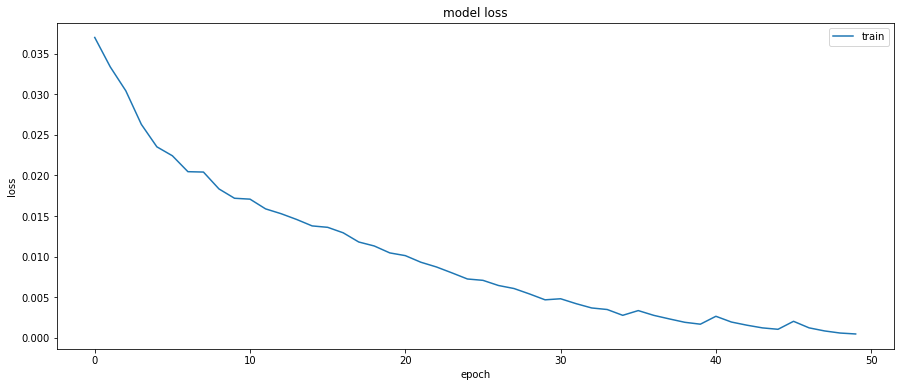

In [41]:
figsize(15,6)
plt.plot(history_loss)
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train'], loc='upper right')
plt.show()

In [246]:
# train_acc_5th = train_accs[4::5]
# test_acc_5th = test_accs[4::5]

In [42]:
len(train_accs)

55

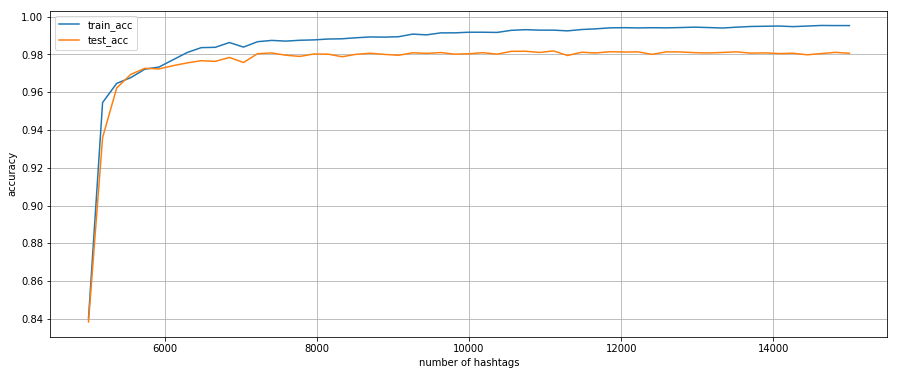

In [43]:
# Plotting the loss
figsize(15,6)
# scalar_space = np.linspace(10000, 20000, 11)
#scalar_space = np.linspace(5000, 15000, 12)
scalar_space = np.linspace(5000, 15000, len(train_accs))

plt.plot(scalar_space, train_accs, label='train_acc')
plt.plot(scalar_space, test_accs, label='test_acc')
plt.xlabel('number of hashtags')
plt.ylabel('accuracy')
plt.grid()
plt.legend()

In [67]:
# from keras.utils import plot_model
# plot_model(model_al, to_file='model.png', show_shapes=True, show_layer_names=True)

In [ ]:
# from IPython.display import SVG
# from keras.utils.vis_utils import model_to_dot

# SVG(model_to_dot(model).create(prog='dot', format='svg'))

# Char embeddings visualization
## TSNE and SVD

In [44]:
from sklearn.manifold import TSNE
from sklearn.decomposition import TruncatedSVD
import seaborn as sns

In [45]:
embeddings = model.layers[1].get_weights()[0]
len(embeddings)

73

Sound distribution for colours:

In [46]:
vowels = 'аАеЕиИоОуУыЫяЯэЭюЮ'
#neutral = ",.-' "
nums = '0123456789_'

sound_distribution = []
for i in all_chars:
    if i in vowels:
        sound_distribution.append(0)
    elif i in nums:
         sound_distribution.append(2)
    else:
        sound_distribution.append(1)

In [47]:
def label_point(x, y, val, ax):
    a = pd.concat({'X': x, 'Y': y, 'letters': val}, axis=1)
    for i, point in a.iterrows():
        ax.text(point['X']+.02, point['Y'], str(point['letters']))

In [48]:
def build_plot(tx, ty, all_letters, sound_distribution):
    df = pd.DataFrame({'X': tx, 'Y': ty, 'letters' : all_letters, 'color':sound_distribution})

    tf = sns.lmplot('X', # Horizontal axis
           'Y', # Vertical axis
           data=df, # Data source
           fit_reg=False, # Don't fix a regression line
           size = 5,
           aspect = 2,
           hue="color", legend=False)

    label_point(df['X'], df['Y'], df['letters'], plt.gca())  

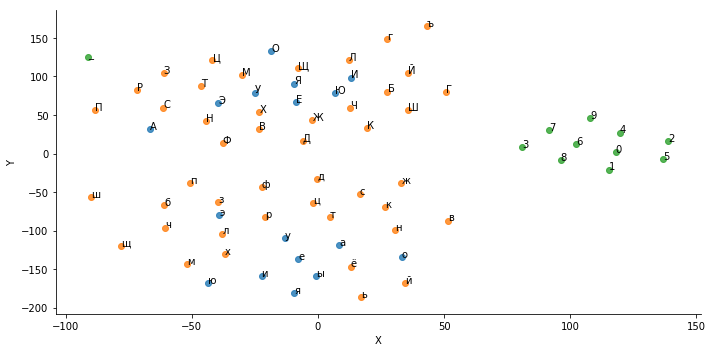

In [49]:
tsne_model = TSNE(n_components=2, random_state=0)
tsne_vectors = tsne_model.fit_transform(embeddings)
tx, ty = tsne_vectors[:, 0], tsne_vectors[:, 1]
build_plot(tx, ty, list(all_chars), sound_distribution)

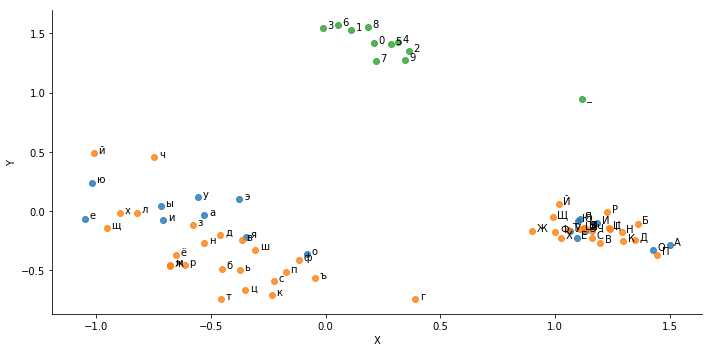

In [50]:
svd_model = TruncatedSVD(n_components=4, random_state=0)
svd_vectors = svd_model.fit_transform(embeddings)
sx, sy = svd_vectors[:, 0], svd_vectors[:, 1]
build_plot(sx, sy, list(all_chars), sound_distribution)

# Distribution of incorrect answers by hashtag types

In [144]:
test_words = test_data_start.hashtag.values
test_tags = test_data_start.true_segmentation.values
test_classes = test_data_start.hashtag_class.values
test_words, test_tags = to_matrix(test_words, char_to_id),to_matrix(test_tags,tag_to_id)

#predict tag probabilities of shape [batch,time,n_tags]
predicted_tag_probabilities = model.predict(test_words,verbose=1)
predicted_tags = predicted_tag_probabilities.argmax(axis=-1)

3750/3750 [==============================] - 5s 1ms/step


In [150]:
classes_dict = {i+1: 0 for i in np.unique(test_classes)}

In [151]:
classes_dict

{1: 0, 2: 0, 3: 0, 4: 0, 5: 0, 6: 0, 7: 0, 8: 0, 9: 0, 10: 0, 11: 0}

In [153]:
tmp = [np.sum(i) for i in (predicted_tags == test_tags)]
#tmp = np.logical_and(predicted_tags == test_tags)
for i, el in enumerate(tmp):
    if el != 55:
        hash_class = test_classes[i]
        classes_dict[hash_class+1] += 1

In [154]:
classes_dict

{1: 9, 2: 18, 3: 11, 4: 111, 5: 13, 6: 24, 7: 55, 8: 84, 9: 2, 10: 4, 11: 5}

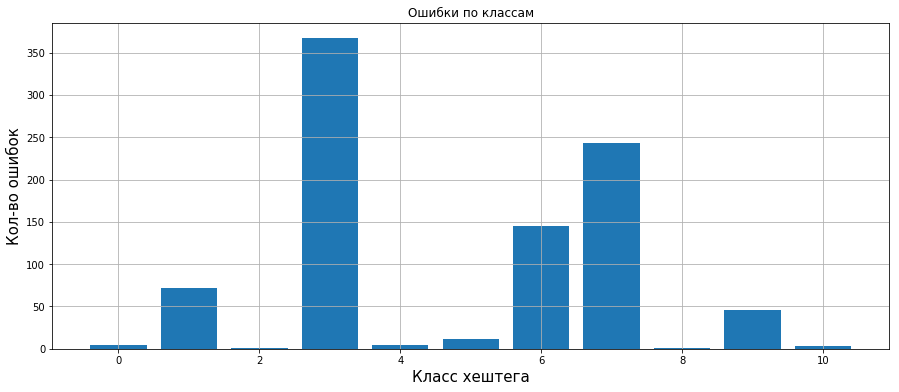

In [209]:
#import matplotlib.pyplot as plt
figsize(15,6)
x = classes_dict.keys()
y = classes_dict.values()
plt.title('Ошибки по классам')
plt.xlabel("Класс хештега", fontsize=15)
plt.ylabel("Кол-во ошибок", fontsize=15)
plt.bar(x, y)
plt.grid()

10 iterations   
each has 5 epochs

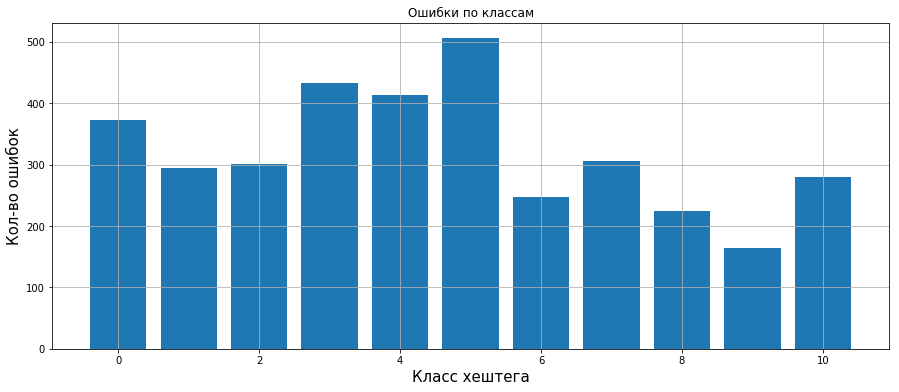

In [63]:
#import matplotlib.pyplot as plt
figsize(15,6)
x = classes_dict.keys()
y = classes_dict.values()
plt.title('Ошибки по классам')
plt.xlabel("Класс хештега", fontsize=15)
plt.ylabel("Кол-во ошибок", fontsize=15)
plt.bar(x, y)
plt.grid()

# Active Learning

In [57]:
def compute_test_accuracy_al(model):
    #TRAIN_ACC
    test_words = test_data.hashtag.values
    test_tags = test_data.true_segmentation.values
    test_words,test_tags = to_matrix(test_words, char_to_id),to_matrix(test_tags,tag_to_id)
    
    #predict tag probabilities of shape [batch,time,n_tags]
    predicted_tag_probabilities = model.predict(test_words,verbose=1)
    predicted_tags = predicted_tag_probabilities.argmax(axis=-1)

    #compute accurary excluding padding
    numerator = np.sum(np.logical_and((predicted_tags == test_tags),(test_words != 0)))
    denominator = np.sum(test_words != 0)
    
    train_acc = float(numerator)/denominator
    return train_acc

train_accs_al = []
test_accs_al = []

class EvaluateAccuracy_al(keras.callbacks.Callback):
    def on_epoch_end(self,epoch,logs=None):
        sys.stdout.flush()
        print("\nMeasuring validation accuracy...")
        train_acc = compute_test_accuracy_al(self.model)
        train_accs_al.append(train_acc)
        print("\nValidation accuracy: %.5f\n"%train_acc)
        sys.stdout.flush()
        

In [1]:
def checker(words, predicted_tag_probabilities):
    "gets probability of segmentation"
    res = []
    for w, predicted_tag_prob in tqdm(zip(words, predicted_tag_probabilities)):
        prob = np.prod(predicted_tag_prob.max(axis=-1))/len(predicted_tag_prob)
        res.append((w, prob))
    return re

In [59]:
df_15k = pd.read_csv("data_15k_with_classes_new.csv", index_col=None).iloc[:, 1:]
df_15k.head()

,hashtag,hashtag_class,true_segmentation
0,подтопленными,5,0000000000001
1,службыкинологической7центр,7,00000100000000000001100001
2,человек7007россии,6,00000010001000001
3,компанией,5,000000001
4,поступилосообщениелетней,7,000000001000000001000001


In [60]:
history_loss_al = []

In [61]:
df_15k_shuffled = shuffle(df_15k)
start_1k = df_15k_shuffled.iloc[:1000]

In [62]:
model_al = keras.models.Sequential()
model_al.add(L.InputLayer([None], dtype='int32'))
model_al.add(L.Embedding(len(all_chars), 50)) # dim 100
model_al.add(L.Bidirectional(L.LSTM(64, return_sequences=True)))
stepwise_dense = L.Dense(2, activation='softmax')
stepwise_dense = L.TimeDistributed(stepwise_dense)
model_al.add(stepwise_dense)

In [63]:
model_al.compile('adam', 'categorical_crossentropy')

In [65]:
train_data = start_1k
test_data = df_15k_shuffled.iloc[1000:]

In [68]:
for i in range(14):
    history = model_al.fit_generator(generate_batches(train_data), len(train_data)/BATCH_SIZE, 
                                     callbacks=[EvaluateAccuracy_al()], epochs=5,)
    history_loss_al += history.history['loss']
    
    test_words_al_text = test_data.hashtag.values
    test_tags_al = test_data.true_segmentation.values
    test_words_al, test_tags_al = to_matrix(test_words_al_text, char_to_id), to_matrix(test_tags_al, tag_to_id)

    #predict tag probabilities of shape [batch,time,n_tags]
    predicted_tag_probabilities = model_al.predict(test_words_al,verbose=1)
    probs = checker(test_words_al_text, predicted_tag_probabilities)
    probs_sorted = sorted(probs, key=operator.itemgetter(1), reverse=False)
    add_1k = [i[0] for i in probs_sorted[:1000]]
    mrg_1k = df_15k_shuffled.loc[df_15k_shuffled['hashtag'].isin(add_1k)]
    
    train_data = pd.concat([train_data, mrg_1k])
    test_data = df_15k_shuffled.loc[~df_15k_shuffled['hashtag'].isin(train_data.hashtag.tolist())]
    print(i)

Epoch 1/5
32/31 [==============================] - 6s 180ms/step - loss: 0.4065

Measuring validation accuracy...
14000/14000 [==============================] - 13s 911us/step

Validation accuracy: 0.82967

Epoch 2/5
32/31 [==============================] - 3s 86ms/step - loss: 0.2478

Measuring validation accuracy...
14000/14000 [==============================] - 14s 1ms/step

Validation accuracy: 0.82967

Epoch 3/5
32/31 [==============================] - 3s 102ms/step - loss: 0.2164

Measuring validation accuracy...
14000/14000 [==============================] - 15s 1ms/step

Validation accuracy: 0.82967

Epoch 4/5
32/31 [==============================] - 3s 100ms/step - loss: 0.1960

Measuring validation accuracy...
14000/14000 [==============================] - 15s 1ms/step

Validation accuracy: 0.83423

Epoch 5/5
32/31 [==============================] - 3s 105ms/step - loss: 0.1571

Measuring validation accuracy...
14000/14000 [==============================] - 14s 990us/step

Va

14000it [00:00, 33512.46it/s]


0
Epoch 1/5
63/62 [==============================] - 8s 127ms/step - loss: 0.1082

Measuring validation accuracy...
13000/13000 [==============================] - 13s 976us/step

Validation accuracy: 0.94348

Epoch 2/5
63/62 [==============================] - 13s 201ms/step - loss: 0.0659

Measuring validation accuracy...
13000/13000 [==============================] - 15s 1ms/step

Validation accuracy: 0.95665

Epoch 3/5
63/62 [==============================] - 11s 168ms/step - loss: 0.0556

Measuring validation accuracy...
13000/13000 [==============================] - 18s 1ms/step

Validation accuracy: 0.96080

Epoch 4/5
63/62 [==============================] - 9s 136ms/step - loss: 0.0495

Measuring validation accuracy...
13000/13000 [==============================] - 12s 945us/step

Validation accuracy: 0.96313

Epoch 5/5
63/62 [==============================] - 12s 192ms/step - loss: 0.0460

Measuring validation accuracy...
13000/13000 [==============================] - 14s 1ms/st

13000it [00:00, 16352.29it/s]


1
Epoch 1/5
94/93 [==============================] - 19s 198ms/step - loss: 0.0661

Measuring validation accuracy...
12000/12000 [==============================] - 18s 2ms/step

Validation accuracy: 0.97419

Epoch 2/5
94/93 [==============================] - 17s 183ms/step - loss: 0.0578

Measuring validation accuracy...
12000/12000 [==============================] - 22s 2ms/step

Validation accuracy: 0.97671

Epoch 3/5
94/93 [==============================] - 15s 161ms/step - loss: 0.0518

Measuring validation accuracy...
12000/12000 [==============================] - 18s 2ms/step

Validation accuracy: 0.97806

Epoch 4/5
94/93 [==============================] - 24s 256ms/step - loss: 0.0487

Measuring validation accuracy...
12000/12000 [==============================] - 17s 1ms/step

Validation accuracy: 0.97895

Epoch 5/5
94/93 [==============================] - 15s 160ms/step - loss: 0.0446

Measuring validation accuracy...
12000/12000 [==============================] - 14s 1ms/step

12000it [00:00, 21818.02it/s]


2
Epoch 1/5
125/125 [==============================] - 23s 186ms/step - loss: 0.0335

Measuring validation accuracy...
11000/11000 [==============================] - 25s 2ms/step

Validation accuracy: 0.98990

Epoch 5/5
125/125 [==============================] - 34s 269ms/step - loss: 0.0317

Measuring validation accuracy...
11000/11000 [==============================] - 20s 2ms/step

Validation accuracy: 0.99025

11000/11000 [==============================] - 14s 1ms/step


11000it [00:00, 12636.88it/s]


3
Epoch 1/5
219/218 [==============================] - 70s 319ms/step - loss: 0.0198

Measuring validation accuracy...
8000/8000 [==============================] - 23s 3ms/step

Validation accuracy: 0.99924

Epoch 2/5
219/218 [==============================] - 65s 297ms/step - loss: 0.0182

Measuring validation accuracy...
8000/8000 [==============================] - 15s 2ms/step

Validation accuracy: 0.99924

Epoch 3/5
219/218 [==============================] - 65s 298ms/step - loss: 0.0165

Measuring validation accuracy...
8000/8000 [==============================] - 11s 1ms/step

Validation accuracy: 0.99924

Epoch 4/5
219/218 [==============================] - 47s 216ms/step - loss: 0.0150

Measuring validation accuracy...
8000/8000 [==============================] - 12s 2ms/step

Validation accuracy: 0.99924

Epoch 5/5
219/218 [==============================] - 48s 219ms/step - loss: 0.0137

Measuring validation accuracy...
8000/8000 [==============================] - 12s 1ms/step

8000it [00:00, 8310.82it/s] 


6
Epoch 1/5
250/250 [==============================] - 69s 274ms/step - loss: 0.0118

Measuring validation accuracy...
7000/7000 [==============================] - 10s 1ms/step

Validation accuracy: 0.99972

Epoch 2/5
250/250 [==============================] - 58s 231ms/step - loss: 0.0099

Measuring validation accuracy...
7000/7000 [==============================] - 7s 1ms/step

Validation accuracy: 0.99972

Epoch 4/5
250/250 [==============================] - 51s 205ms/step - loss: 0.0090

Measuring validation accuracy...
7000/7000 [==============================] - 12s 2ms/step

Validation accuracy: 0.99972

Epoch 5/5
250/250 [==============================] - 44s 176ms/step - loss: 0.0081

Measuring validation accuracy...
7000/7000 [==============================] - 8s 1ms/step

Validation accuracy: 0.99972

7000/7000 [==============================] - 8s 1ms/step


7000it [00:02, 3144.90it/s] 


7
Epoch 1/5
282/281 [==============================] - 48s 171ms/step - loss: 0.0069

Measuring validation accuracy...
6000/6000 [==============================] - 9s 1ms/step

Validation accuracy: 0.99986

Epoch 2/5
282/281 [==============================] - 48s 169ms/step - loss: 0.0062

Measuring validation accuracy...
6000/6000 [==============================] - 7s 1ms/step

Validation accuracy: 0.99986

Epoch 3/5
282/281 [==============================] - 64s 228ms/step - loss: 0.0055

Measuring validation accuracy...
6000/6000 [==============================] - 10s 2ms/step

Validation accuracy: 0.99986

Epoch 4/5
282/281 [==============================] - 76s 270ms/step - loss: 0.0051

Measuring validation accuracy...
6000/6000 [==============================] - 13s 2ms/step

Validation accuracy: 0.99986

Epoch 5/5
282/281 [==============================] - 63s 222ms/step - loss: 0.0046

Measuring validation accuracy...
6000/6000 [==============================] - 8s 1ms/step

V

6000it [00:00, 17219.35it/s]


8
Epoch 1/5
313/312 [==============================] - 59s 189ms/step - loss: 0.0036

Measuring validation accuracy...
5000/5000 [==============================] - 10s 2ms/step

Validation accuracy: 0.99988

Epoch 2/5
313/312 [==============================] - 71s 227ms/step - loss: 0.0033

Measuring validation accuracy...
5000/5000 [==============================] - 13s 3ms/step

Validation accuracy: 0.99988

Epoch 3/5
313/312 [==============================] - 90s 286ms/step - loss: 0.0028

Measuring validation accuracy...
5000/5000 [==============================] - 14s 3ms/step

Validation accuracy: 0.99988

Epoch 4/5
313/312 [==============================] - 85s 273ms/step - loss: 0.0026

Measuring validation accuracy...
5000/5000 [==============================] - 8s 2ms/step

Validation accuracy: 0.99988

Epoch 5/5
313/312 [==============================] - 49s 156ms/step - loss: 0.0022

Measuring validation accuracy...
5000/5000 [==============================] - 7s 1ms/step



5000it [00:00, 11124.91it/s]


9
Epoch 1/5
344/343 [==============================] - 57s 166ms/step - loss: 0.0020

Measuring validation accuracy...
4000/4000 [==============================] - 5s 1ms/step

Validation accuracy: 0.99997

Epoch 2/5
344/343 [==============================] - 56s 162ms/step - loss: 0.0020

Measuring validation accuracy...
4000/4000 [==============================] - 5s 1ms/step

Validation accuracy: 0.99997

Epoch 3/5
344/343 [==============================] - 53s 155ms/step - loss: 0.0019

Measuring validation accuracy...
4000/4000 [==============================] - 5s 1ms/step

Validation accuracy: 0.99997

Epoch 4/5
344/343 [==============================] - 63s 182ms/step - loss: 0.0014

Measuring validation accuracy...
4000/4000 [==============================] - 9s 2ms/step

Validation accuracy: 0.99997

Epoch 5/5
344/343 [==============================] - 73s 213ms/step - loss: 0.0012

Measuring validation accuracy...
4000/4000 [==============================] - 10s 2ms/step

Va

4000it [00:00, 10894.11it/s]


10
Epoch 1/5
375/375 [==============================] - 79s 211ms/step - loss: 0.0011

Measuring validation accuracy...
3000/3000 [==============================] - 4s 1ms/step

Validation accuracy: 0.99996

Epoch 2/5
375/375 [==============================] - 96s 255ms/step - loss: 0.0010

Measuring validation accuracy...
3000/3000 [==============================] - 5s 2ms/step

Validation accuracy: 0.99996

Epoch 3/5
375/375 [==============================] - 55s 146ms/step - loss: 0.0010

Measuring validation accuracy...
3000/3000 [==============================] - 4s 1ms/step

Validation accuracy: 0.99996

Epoch 4/5
375/375 [==============================] - 77s 204ms/step - loss: 9.4553e-04

Measuring validation accuracy...
3000/3000 [==============================] - 3s 972us/step

Validation accuracy: 0.99996

Epoch 5/5
375/375 [==============================] - 96s 255ms/step - loss: 6.8730e-04

Measuring validation accuracy...
3000/3000 [==============================] - 4s 1m

3000it [00:00, 18388.57it/s]

11
Epoch 1/5


407/406 [==============================] - 98s 240ms/step - loss: 5.2293e-04

Measuring validation accuracy...
2000/2000 [==============================] - 4s 2ms/step

Validation accuracy: 1.00000

Epoch 2/5
407/406 [==============================] - 100s 245ms/step - loss: 5.6542e-04

Measuring validation accuracy...
2000/2000 [==============================] - 4s 2ms/step

Validation accuracy: 1.00000

Epoch 3/5
407/406 [==============================] - 84s 207ms/step - loss: 9.5106e-04

Measuring validation accuracy...
2000/2000 [==============================] - 3s 2ms/step

Validation accuracy: 1.00000

Epoch 4/5
407/406 [==============================] - 82s 203ms/step - loss: 0.0012

Measuring validation accuracy...
2000/2000 [==============================] - 3s 2ms/step

Validation accuracy: 1.00000

Epoch 5/5
438/437 [==============================] - 103s 234ms/step - loss: 2.2848e-04

Measuring validation accuracy...
1000/1000 [==============================] - 2s 2ms/ste

1000it [00:00, 13731.33it/s]

13


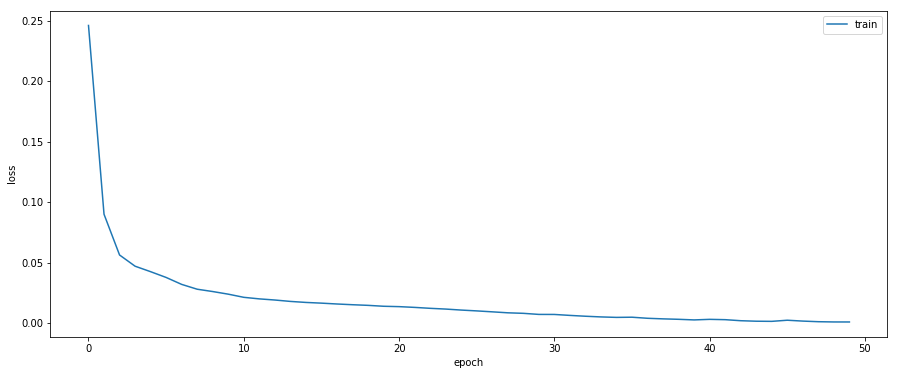

In [169]:
figsize(15,6)
plt.plot(history_loss)
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train'], loc='upper right')
plt.show()

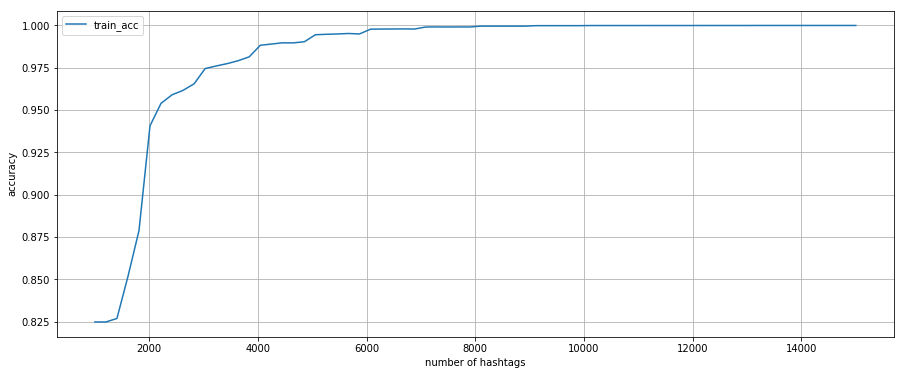

In [179]:
figsize(15,6)
scalar_space = np.linspace(1000, 15000, len(train_accs_al))

plt.plot(scalar_space, train_accs_al, label='train_acc')
plt.xlabel('number of hashtags')
plt.ylabel('accuracy')
plt.grid()
plt.legend()

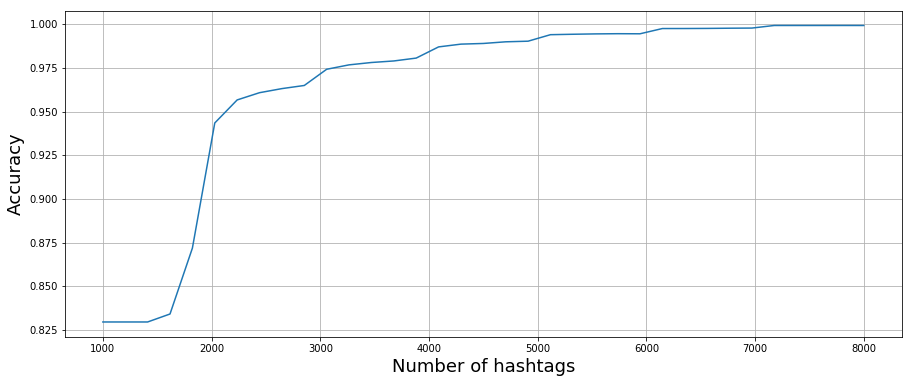

In [73]:
figsize(15,6)
scalar_space = np.linspace(1000, 8000, len(train_accs_al[:35]))
plt.plot(scalar_space, train_accs_al[:35])
plt.xlabel('Number of hashtags', fontsize=18)
plt.ylabel('Accuracy', fontsize=18)
plt.grid()

# AL experiment

top 7k of data after active learning    
7 epochs

In [25]:
data_al = pd.read_csv("./data_al.csv", index_col=None).iloc[:, 1:]
data_al.head()

,hashtag,hashtag_class,true_segmentation
0,ЩСШ6562,9,0010001
1,ситуации_218,0,000000011001
2,словокотороебудете_Открыла,3,00001000000100000110000001
3,красивых,5,00000001
4,МогутЗаказать,10,0000100000001


In [26]:
model_test = keras.models.Sequential()
model_test.add(L.InputLayer([None], dtype='int32'))
model_test.add(L.Embedding(len(all_chars), 50)) # dim 100
model_test.add(L.Bidirectional(L.LSTM(64, return_sequences=True)))
stepwise_dense = L.Dense(2, activation='softmax')
stepwise_dense = L.TimeDistributed(stepwise_dense)
model_test.add(stepwise_dense)

In [27]:
model_test.compile('adam', 'categorical_crossentropy')

In [28]:
train_data = data_al.iloc[:7000]
test_data = data_al.iloc[7000:]

In [29]:
history = model_test.fit_generator(generate_batches(train_data), len(train_data)/BATCH_SIZE,
                                   callbacks=[EvaluateAccuracy()], epochs=7,)

Epoch 1/7
219/218 [==============================] - 30s 136ms/step - loss: 0.2178

Measuring validation accuracy...
1950/1950 [==============================] - 1s 689us/step

Validation accuracy: 0.96110


Real test_data accuracy: 0.92823

Epoch 2/7
219/218 [==============================] - 29s 132ms/step - loss: 0.0868

Measuring validation accuracy...
1950/1950 [==============================] - 1s 675us/step

Validation accuracy: 0.98435


Real test_data accuracy: 0.96677

Epoch 3/7
219/218 [==============================] - 29s 131ms/step - loss: 0.0695

Measuring validation accuracy...
1950/1950 [==============================] - 1s 701us/step

Validation accuracy: 0.99059


Real test_data accuracy: 0.97278

Epoch 4/7
219/218 [==============================] - 29s 131ms/step - loss: 0.0563

Measuring validation accuracy...
1950/1950 [==============================] - 1s 698us/step

Validation accuracy: 0.99499


Real test_data accuracy: 0.97842

Epoch 5/7
219/218 [=============

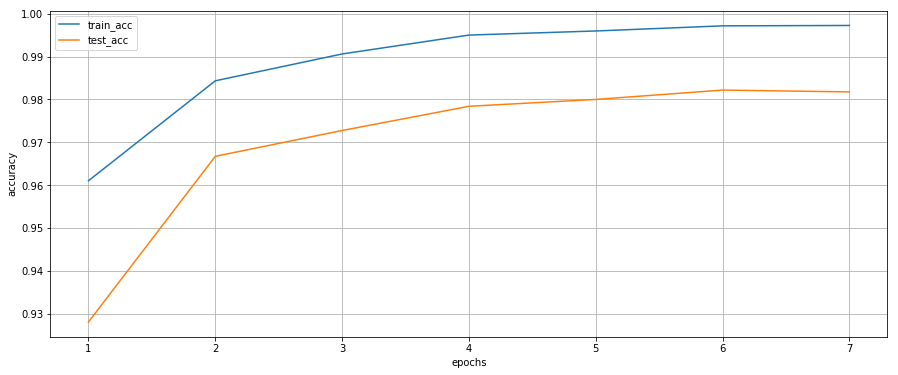

In [32]:
figsize(15,6)
# scalar_space = np.linspace(10000, 20000, 11)
#scalar_space = np.linspace(5000, 15000, 12)
scalar_space = np.linspace(1, 7, len(train_accs))

plt.plot(scalar_space, train_accs, label='train_acc')
plt.plot(scalar_space, test_accs, label='test_acc')
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.grid()
plt.legend()

In [65]:
embeddings = model_test.layers[1].get_weights()[0]
len(embeddings)

73

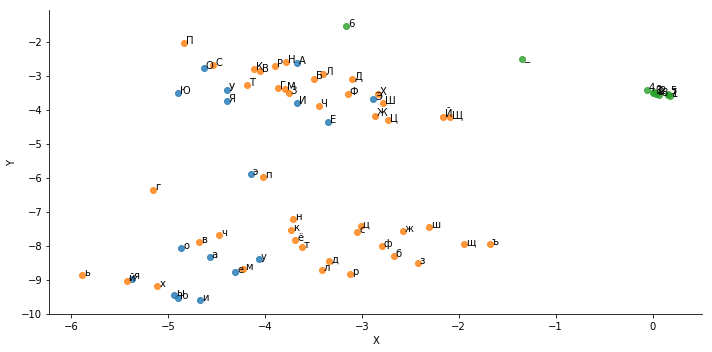

In [71]:
tsne_model = TSNE(n_components=2, random_state=0)
tsne_vectors = tsne_model.fit_transform(embeddings)
tx, ty = tsne_vectors[:, 0], tsne_vectors[:, 1]
build_plot(tx, ty, list(all_chars), sound_distribution)

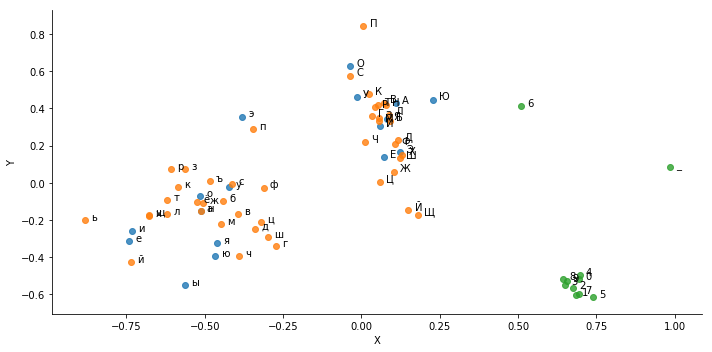

In [72]:
svd_model = TruncatedSVD(n_components=4, random_state=0)
svd_vectors = svd_model.fit_transform(embeddings)
sx, sy = svd_vectors[:, 0], svd_vectors[:, 1]
build_plot(sx, sy, list(all_chars), sound_distribution)

In [74]:
hashtags_x = train_data.hashtag.values
hashtags_y = train_data.hashtag_class.values

In [75]:
classes_dict_al = {i: 0 for i in np.unique(hashtags_y)}

In [79]:
for i, el in enumerate(hashtags_y):
    classes_dict_al[el] += 1

In [80]:
classes_dict_al

{0: 404,
 1: 571,
 2: 335,
 3: 1775,
 4: 298,
 5: 474,
 6: 1022,
 7: 1215,
 8: 131,
 9: 391,
 10: 384}

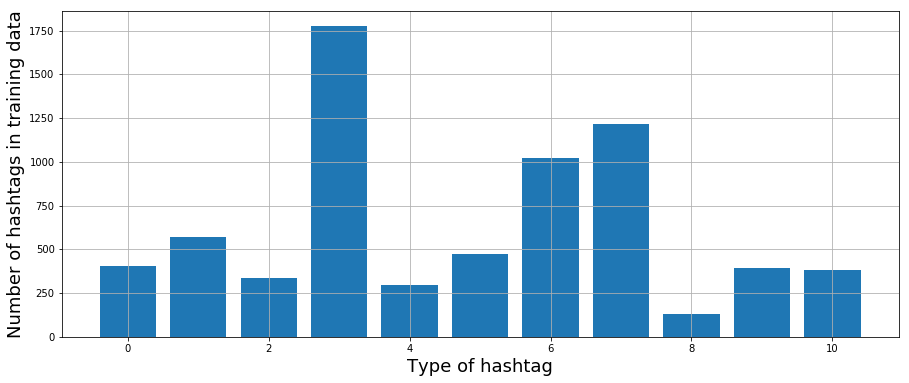

In [56]:
figsize(15,6)
x = classes_dict_al.keys()
y = classes_dict_al.values()
plt.xlabel("Type of hashtag", fontsize=18)
plt.ylabel("Number of hashtags in training data", fontsize=18)
plt.bar(x, y)
plt.grid()

# Leave-one-out

2000 экспериментов

потом усредняем accuracy

In [63]:
data = pd.read_csv("./dummy_data_all_types.csv", index_col=None).iloc[:, 1:]

history_loss = []

for i in range(len(real_test_data)):

    model = keras.models.Sequential()
    model.add(L.InputLayer([None], dtype='int32'))
    model.add(L.Embedding(len(all_chars), 50)) # dim 100
    model.add(L.Bidirectional(L.LSTM(64, return_sequences=True)))

    #add top layer that predicts tag probabilities

    stepwise_dense = L.Dense(2, activation='softmax')
    stepwise_dense = L.TimeDistributed(stepwise_dense)

    model.add(stepwise_dense)
    model.compile('adam', 'categorical_crossentropy')

    
    if i == 0:
        train_data = pd.concat([data, real_test_data.iloc[1:]])
        test_data = real_test_data.iloc[[0]]
    elif i == len(real_test_data):
        train_data = pd.concat([data, real_test_data.iloc[:-1]])
        test_data = real_test_data.iloc[[-1]]
    else:   
        train_data = pd.concat([data, real_test_data.iloc[:i], real_test_data.iloc[i+1:]])
        test_data = real_test_data.iloc[[i]]
    
    
    history = model.fit_generator(generate_batches(train_data), len(train_data)/BATCH_SIZE,
                    callbacks=[EvaluateAccuracy()], epochs=1,)
    
    #histoty_loss += history.history['loss']
    history_loss.append(history.history['loss'])
    print('ITERATION: ', i)

Epoch 1/1
374/373 [==============================] - 47s 127ms/step - loss: 0.1336

Measuring validation accuracy...
1943/1943 [==============================] - 1s 710us/step

Validation accuracy: 0.93333


Real test_data accuracy: 0.97096

ITERATION:  0
Epoch 1/1
374/373 [==============================] - 48s 128ms/step - loss: 0.1414

Measuring validation accuracy...
1943/1943 [==============================] - 1s 715us/step

Validation accuracy: 0.85714


Real test_data accuracy: 0.96861

ITERATION:  1
Epoch 1/1
374/373 [==============================] - 48s 128ms/step - loss: 0.1338

Measuring validation accuracy...
1943/1943 [==============================] - 1s 720us/step

Validation accuracy: 0.75000


Real test_data accuracy: 0.97198

ITERATION:  2
Epoch 1/1
374/373 [==============================] - 49s 131ms/step - loss: 0.1393

Measuring validation accuracy...
1943/1943 [==============================] - 1s 760us/step

Validation accuracy: 0.75000


Real test_data accuracy:

KeyboardInterrupt: 

In [64]:
len(history_loss)

23

In [70]:
#history_loss = [i[0] for i in history_loss]
np.mean(history_loss)

0.13937908790438247